# Testes de viabilidade, aplicação de algorítmos de machine learning para tradding

# Primeiro Passo, Aquisição dos dados OHLCV direto da exchange

# Pegando os Candles da API

In [7]:
import requests, json
from binance.client import Client
from binance.enums import *

import pandas as pd
import numpy as np
import time
from datetime import datetime

from math import pi
from bokeh.plotting import figure, show, output_file
from bokeh.sampledata.stocks import MSFT
from bokeh.models import Band
%matplotlib inline

from pyti.exponential_moving_average import exponential_moving_average as ema
from pyti.aroon import aroon_down, aroon_up
from pyti.ichimoku_cloud import tenkansen, kijunsen, chiku_span, senkou_a, senkou_b
from pyti.momentum import momentum

import matplotlib.pyplot as plt
import seaborn as sns


class Aquisition(object):
    def __init__(self):
        self.client = Client('', '')
        self.df = ""
        
    def getCandles(self):
        self.df = pd.DataFrame(columns= ['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time'])
        candles = self.client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1DAY)
        opentime, lopen, lhigh, llow, lclose, lvol, closetime = [], [], [], [], [], [], []
        for candle in candles:
            opentime.append(candle[0])
            lopen.append(candle[1])
            lhigh.append(candle[2])
            llow.append(candle[3])
            lclose.append(candle[4])
            lvol.append(candle[5])
            closetime.append(candle[6])
        self.df['Open_time'] = opentime
        self.df["date"] = opentime
        self.df['Open'] = np.array(lopen).astype(np.float)
        self.df['High'] = np.array(lhigh).astype(np.float)
        self.df['Low'] = np.array(llow).astype(np.float)
        self.df['Close'] = np.array(lclose).astype(np.float)
        self.df['Volume'] = np.array(lvol).astype(np.float)
        self.df['Close_time'] = closetime
        self.df["date"] = pd.to_datetime(self.df['date'],unit='ms')
        return self.df
    
    def getPriceNow(self):
        r = requests.get(
            "https://www.binance.com/api/v3/ticker/price?symbol=BTCUSDT")
        r = r.content
        jsonResponse = json.loads(r.decode('utf-8'))
        return float(jsonResponse['price'])
    
    def plotCandles(self):
        df = self.df[450:]
        df["date"] = df["Open_time"]
        df["date"] = pd.to_datetime(self.df['date'],unit='ms')
        inc = df.Close > df.Open
        dec = df.Open > df.Close
        w = 12*60*60*1000 # half day in ms
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "BITCOIN Candlestick")
        p.xaxis.major_label_orientation = pi/4
        p.grid.grid_line_alpha=0.3
        p.segment(df.date, df.High, df.date, df.Low, color="black")
        p.vbar(df.date[inc], w, df.Open[inc], df.Close[inc], fill_color="#006400", line_color="black")
        p.vbar(df.date[dec], w, df.Open[dec], df.Close[dec], fill_color="#F2583E", line_color="black")
        output_file("candlestick.html", title="candlestick.py Grafico de Candles")
        show(p)  

## Calculando indicador

***Bandas de boillinger- Decidi implementar esse indicador por esporte... os demais são importados do pity*** 

In [8]:
class Bbands(Aquisition):  
    
    def __init__(self, nDer = 2, period = 20):
        super(Bbands, self).__init__()
        self.candles = super().getCandles()
        self.nDer = nDer
        self.period = period
    
    def calcBands(self):
        # a formula eh a SMA +- desvio*n_desvios
        self.candles['30 Day MA'] = self.candles['Close'].rolling(window=self.period).mean()
        self.candles['30 Day STD'] = self.candles['Close'].rolling(window=self.period).std()
        self.candles['Upper Band'] = self.candles['30 Day MA'] + (self.candles['30 Day STD'] * self.nDer)
        self.candles['Lower Band'] = self.candles['30 Day MA'] - (self.candles['30 Day STD'] * self.nDer)
        
    def plotSetting(self, df):
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "Bbands Chart")
        p.xaxis.major_label_orientation = pi/4
        p.grid.grid_line_alpha=0.3
        p.line(df.date, df.Close, line_color="black")
        p.line(df.date, df['30 Day MA'], line_color="red", legend="30 Day MA", muted_alpha=0.2)
        p.line(df.date, df['Upper Band'], line_color="blue", legend="Upper Band", muted_alpha=0.2)
        p.line(df.date, df['Lower Band'], line_color="green", legend="Lower Band", muted_alpha=0.2)
        
        p.legend.location = "top_left"
        p.legend.click_policy="mute"
        return p
        
    def plotBands(self):
        df = self.candles
        p = self.plotSetting(df)
        output_file("candlestick.html", title="candlestick.py Bbands")
        show(p)  
        
    def detectCross(self):
        #essa função detecta o cruzamento do preço do ativo com as bandas, insere 1 no dataframe 
        #com cruzamento superior e 0 inferior
        self.calcBands()
        #self.candles['up_cross'] = np.where((self.candles['Close'] >= self.candles['Upper Band'])
        #             , self.candles['Close'], '')       
        self.candles['up_cross'] = np.where((self.candles['Close'] >= self.candles['Upper Band'])
             , 1, 0)
        
        #self.candles['down_cross'] = np.where((self.candles['Close'] <= self.candles['Lower Band'])
         #    , self.candles['Close'],  '')
        self.candles['down_cross'] = np.where((self.candles['Close'] <= self.candles['Lower Band'])
             , 1,  0)
        
        
        #aqui pra plotar com bokeh....
        p = self.plotSetting(self.candles)        
        p.circle(self.candles.date, self.candles['up_cross'], size=5, color="red", alpha=1)
        p.circle(self.candles.date, self.candles['down_cross'], size=5, color="green", alpha=1)   
        output_file("candlestick.html", title="candlestick.py Bbands")
        #show(p)  
        
    def generateSignal(self):
        # geração de sinal buy and sell somente com a banda (estrategia classica não sera usada)
        aq = Aquisition()
        self.candles = aq.getCandles()
        
        ma = self.candles['Close'][480:].mean()
        sma = self.candles['Close'][480:].std()
        ub = ma + (sma * 2)
        lb = ma - (sma * 2)
        print(type(ub))
        price  = aq.getPriceNow()
        
        if(price < lb):
            return 'buy'
        
        if(price > ub):
            return 'sell'
        
        else:
            return 'hold'

# Analizando Correlação -- depois pretendo fazer uma feature selection com base na correlação

In [9]:
class Corr(object):
    def __init__(self, df):
        self.df = df
        try:
            self.df = self.df.drop(['High', 'Low', 'Open'], axis=1)
        except:
            pass
    
    def pearson(self):
        plt.figure(figsize=(12,8))
        kwargs = {'fontsize':12,'color':'black'}
        sns.heatmap(self.df.corr(),annot=True,robust=True)
        plt.title('Correlation Analysis',**kwargs)
        plt.tick_params(length=3,labelsize=12,color='black')
        plt.yticks(rotation=0)
        plt.show()

In [10]:
'''
%%time
df = Aquisition()
c = Corr(df.getCandles())
c.pearson()
'''

'\n%%time\ndf = Aquisition()\nc = Corr(df.getCandles())\nc.pearson()\n'

# A análise de correlação
Não ajudou muito pois as correlações encontradas já eram esperadas como SMA e BBands 

# Criando variável target

#### Ta bem bosta mas vou pensar uma parada mais elaborada, a ideia desse método eh verificar 
#### o preço atual e o preço 10 candles a frente, quando o preço sobe pinta-se o atual de verde e quando desce de vermelho


In [11]:
class Target(object):
    def __init__(self, candles):
        self.candles = candles
        self.buy = [] 
        self.sell = []
        self.hold = []
        self.close = self.candles['Close'].tolist() 
        
        
    def fill(self, vBuy, vSell):
        self.buy.append(vBuy) 
        self.sell.append(vSell)
        
    def testTarget(self):
        for i in range (0, len(self.close)-11):
            if float(self.close[i]) < float(self.close[i+10]):
                self.fill(self.close[i], 'NaN')
            elif float(self.close[i]) > float(self.close[i+10]):
                self.fill('NaN', self.close[i])
                
        for i in range (488, 500):
            self.fill('NaN', 'NaN')
            
        self.candles['buy'] = self.buy
        self.candles['sell'] = self.sell
        
    def plotTargets(self):   
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "Bbands Chart")
        p.xaxis.major_label_orientation = pi/4
        p.grid.grid_line_alpha=0.3

        p.line(self.candles.date, self.candles.Close, line_color="black")

        p.circle(self.candles.date, self.candles['sell'], size=5, color="red", alpha=1, legend='buy')
        p.circle(self.candles.date, self.candles['buy'], size=5, color="green", alpha=1, legend='sell')

        output_file("candlestick.html", title="candlestick.py Bbands")
        show(p)  

In [12]:
df = Aquisition()
tgt = Target(df.getCandles())
tgt.testTarget()
tgt.plotTargets()

# Exemplo de saida:


![img](candles.png)

### OBS: Esse modelo vai ser usado até aparecer uma maneira melhor na minha mente...

# Definição do target

#### Percorre o array do close com o metodo lookahead com 10 candles inserindo 0 (buy) ou 1 (sell) no campo target 

In [13]:
def createTarget(candles):
    
    close = candles['Close'].tolist()
    target = []
    
    for i in range (0, len(close)-11):
        if float(close[i]) < float(close[i+10]):
            target.append(0)

        elif float(close[i]) > float(close[i+10]):
            target.append(1)
            
    for i in range (488, 500):
        target.append('NaN')
        
    candles['target'] = target

# Limpando as colunas NaN apagando todas elas do df inclusive as colunas sell e buy


In [14]:
class cleanData(object):
    def __init__(self, candles):
        self.candles = candles

    def clean(self):
        try:
            self.candles = self.candles.drop(['sell', 'buy'], axis=1)
        except:
            print('Erro apagando sell e buy')
            pass
        
        self.candles = self.candles.dropna()
        for column in self.candles:
            self.candles = self.candles[~self.candles[column].isin(['NaN'])]

        self.candles.to_csv('csv_ok', sep=',', encoding='utf-8')
        return self.candles

# ADICIONANDO TODOS OS INDICADORES AO DATAFRAME


### Tem muita coisa pra fazer aqui
#### Os indicadores iniciais foram escolhidos arbitrariamente, o proximo passo aqui eh fazer uma feature selection pra ver quais acrescentar  e quais retirar...

+ bbands
+ cross das bbancs
+ EMA - 15
+ aaron up e down
+ algumas nuvens de ichimoku

In [15]:
bb = Bbands()
bb.calcBands()
#bb.plotBands()
bb.detectCross()

#adicionando os outros indicadores
candles = bb.candles
candles = candles.drop(['Open_time', 'Close_time'], axis=1)
candles['EMA - 15'] = ema(candles['Close'].tolist(), 15)
candles['aaron down'] = aroon_down(candles['Close'].tolist(), 25)
candles['aaron up'] = aroon_up(candles['Close'].tolist(), 25)
candles['tenkansen'] = tenkansen(candles['Close'].tolist())
candles['kijunsen'] = kijunsen(candles['Close'].tolist())
candles['momentun'] = momentum(candles['Close'], 15)

#Definindo o target
t = Target(candles) 
#t.testTarget()
#t.plotTargets()
createTarget(t.candles)

#Limpando o dataframe
dt = cleanData(t.candles)
candles_no_NaN = dt.clean()
candles_no_NaN.head()

Erro apagando sell e buy


,Open,High,Low,Close,Volume,date,30 Day MA,30 Day STD,Upper Band,Lower Band,up_cross,down_cross,EMA - 15,aaron down,aaron up,tenkansen,kijunsen,momentun,target
25,4175.00,4380.00,4138.10,4378.51,720.353183,2017-09-30,3891.7785,282.691471,4457.161442,3326.395558,0,0,4007.623098,36.0,8.0,3987.190,3940.315,663.56,0
26,4378.49,4406.52,4240.04,4378.48,726.963685,2017-10-01,3900.2790,295.003529,4490.286058,3310.271942,0,0,4066.917463,32.0,4.0,4019.265,3940.315,678.49,0
27,4400.00,4561.63,4360.00,4380.00,655.756974,2017-10-02,3911.0930,308.809836,4528.712673,3293.473327,0,0,4119.311353,28.0,100.0,4020.010,3940.315,344.99,0
28,4380.00,4467.33,4180.80,4310.00,1082.323563,2017-10-03,3929.3585,321.446750,4572.252001,3286.464999,0,0,4148.509083,24.0,96.0,4131.175,3784.510,399.96,0
29,4314.90,4373.00,4142.00,4208.59,868.465101,2017-10-04,3980.3370,275.406421,4531.149842,3429.524158,0,0,4161.840210,20.0,92.0,4131.175,3784.510,308.59,0


# O dataframe esta "pronto" agora só questão de normalizar e rodar os algorítmos

# Definindo target, features e dividindo treino e  teste

In [17]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(candles_no_NaN, test_size=round(len(candles_no_NaN)*0.2))

train['target'] = pd.to_numeric(train['target'], downcast='float')
test['target'] = pd.to_numeric(test['target'], downcast='float')

features = ['Open', 'High', 'Low', 'Close', 'Volume', '30 Day MA',
                   '30 Day STD', 'Upper Band', 'Lower Band', 'up_cross', 'down_cross',
                   'EMA - 15', 'aaron down', 'aaron up', 'tenkansen', 'kijunsen',
                   'momentun']

x_train = train[features]
y_train = train['target']
x_test = test[features]
y_test = test['target']


/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Início de testes com os algorítmos

# Pipelines 

In [45]:
# Scallers pra padronizar os dados no momento testarei 2 nos pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Validações e otimizações
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

#pipelines e gridsearch
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#algoritmos
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Aqui só vou jogar no algorítmo algumas possibilidades com os parametros default...
#### Como transformei o problema em classificação então vou começar com alguns algorítmos do scikit...

#### Crio 3 pipelines e verifico a accuracia de todos com cross validation com 5 dobras


+ pipeline 1 random forest com standart scaller
+ pipeline 2 random forest com minmaxacaller
+ pipeline 3 suport vector machines com minmaxscaller
+ pipeline 4 gradient boosting com minmaxscaller

In [28]:
pip_1 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', RandomForestClassifier())
])

pip_1.fit(x_train, y_train)
np.mean(cross_val_score(pip_1, x_train, y_train, cv=5))

0.8356218684437863

In [34]:
pip_2 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', BaggingClassifier(RandomForestClassifier()))
])

pip_2.fit(x_train, y_train)
np.mean(cross_val_score(pip_2, x_train, y_train, cv=5))

0.8112205356040972

In [30]:
pip_3 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', svm.SVC(gamma='scale'))
])

pip_2.fit(x_train, y_train)
np.mean(cross_val_score(pip_2, x_train, y_train, cv=5))

0.7676791311859805

In [31]:
pip_4 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', GradientBoostingClassifier())
])

pip_2.fit(x_train, y_train)
np.mean(cross_val_score(pip_2, x_train, y_train, cv=5))

0.8194757497223251

### Como esperado por enquanto o GradientBoosting se saiu melhor, porém esses modelos são muito instáveis por enquanto, vai melhorar com aumento do dataset, feature selection e gradient search (um dia...)

# Agora vou criar uma pool de threads pra automatizar essas paradas

In [128]:
# random forest - standart
pip_1 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', RandomForestClassifier())
])

# random forest + minmax + bagging
pip_2 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', BaggingClassifier(RandomForestClassifier()))
])

# random forest + minmax + bagging
pip_3 = Pipeline([
    ('min_max_scaler', Standart()),
    ('clf', BaggingClassifier(RandomForestClassifier()))
])

# svc + minmax
#pip_3 = Pipeline([
#    ('min_max_scaler', MinMaxScaler()),
#    ('clf', svm.SVC(gamma='scale'))
#])

# gradient + minmax
pip_4 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', GradientBoostingClassifier())
])

#ada boost + standart 
pip_5 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', AdaBoostClassifier())
])

# adaboost minmax + bagging
pip_6 = Pipeline([
    ('scaler',MinMaxScaler()),
    ('clf', BaggingClassifier(AdaBoostClassifier()))
])

pip_7 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', BaggingClassifier(AdaBoostClassifier()))
])

#bagging + voting
pip_8 = Pipeline([
    ('scaler',MinMaxScaler()),
    ('clf',  BaggingClassifier(KNeighborsClassifier()))
])


pip_9 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', KNeighborsClassifier())
])


pip_10 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', LogisticRegression())
])

NameError: name 'Standart' is not defined

In [129]:
results = []

import threading
class Threads (threading.Thread):
    def __init__(self, threadID, pipeline):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.pipeline = pipeline
    
    def run(self):
        print("Started thread " + str(self.name))    
        self.evalModel()
    
    def evalModel(self):
        self.pipeline.fit(x_train, y_train)
        
        print( '\n---------------------------------------------------------------------\n ' +
              str(self.pipeline) + '\n RESULT ' + 
              str(np.mean(cross_val_score(self.pipeline, x_train, y_train, cv=5))) +
             '\n---------------------------------------------------------------------\n')

In [126]:
class Process():
    def __init__(self):
        self.pipelines = [pip_1, pip_2, pip_3, pip_4, pip_5, pip_6, pip_7, pip_8, pip_9, pip_10]
        self.threads = []

    def startProcess(self):
        print("Iniciando Treinamentos")
        self.createThreads()
        self.startThreads()
        self.checkThreads()
        
    def createThreads(self):
        for x in range (0, len(self.pipelines)):
            self.threads.append(Threads(x, self.pipelines[x]))
        print("Foram criadas " + str(len(self.threads)) + " threads")
        
    def startThreads(self):
        for thread in self.threads:
            thread.start()
    
    def checkThreads(self):
        i = True
        while(i):
            if (all(thread.is_alive() == False for thread in self.threads)):
                i = False
                print("Threads terminadas")
            else:
                time.sleep(2)

In [127]:
import warnings
warnings.filterwarnings('ignore')

pc = Process()
pc.startProcess()

Iniciando Treinamentos
Foram criadas 10 threads
Started thread Thread-195
Started thread Thread-196
Started thread Thread-197
Started thread Thread-198
Started thread Thread-199
Started thread Thread-200
Started thread Thread-201
Started thread Thread-202
Started thread Thread-203
Started thread Thread-204

---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
 RESULT 0.7569754411946192
---------------------------------------------------------------------


---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fi

/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
Exception in thread Thread-197:
Traceback (most recent call last):
  File "/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-125-56de3be08799>", line 12, in run
    self.evalModel()
  File "<ipython-input-125-56de3be08799>", line 15, in evalModel
    self.pipeline.fit(x_train, y_train)
  File "/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/pipeline.py", line 250, in fit
    self._final_estimator.fit(Xt, y, **fit_params)
  Fi


---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])
 RESULT 0.7487202270763914
---------------------------------------------------------------------


---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
  

/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/ext


---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])
 RESULT 0.805631988152536
---------------------------------------------------------------------



/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/ext


---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])
 RESULT 0.8218151301986918
---------------------------------------------------------------------



/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)



---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, ...estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])
 RESULT 0.8138511662347279
---------------------------------------------------------------------



/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/ext


---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', BaggingClassifier(base_estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])
 RESULT 0.7949643341972109
---------------------------------------------------------------------


---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', BaggingClassifier(base_estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
         bootstrap=True, b

# ==============================================================

# Programação das rotinas do bot ignorar daqui pra baixo, tudo em construção

In [23]:
class Orders(object):
    def createOrder(self, side=SIDE_BUY, quantity=100, price='0.00001'):
        try:
            order = Client.create_test_order(
            symbol='USDTBTC',
            side=side,
            type=ORDER_TYPE_LIMIT,
            timeInForce=TIME_IN_FORCE_GTC,
            quantity=quantity,
            price=price)
        except:
            print('erro create order')
        
    def loginAPI(self):
        pass
    

class Bot(object):
    def __init__(self):
        self.botStatus = {
            'openOrder':'none',
            'lastOperation':'sell',
        }
    
    def checkStrategy(self):
        bb = Bbands()
        return bb.generateSignal()
    
    def checkSignal(self):
        signal = self.checkStrategy()
        if(signal == 'buy'):
            self.updateStatus('yes', signal)
        if (signal == 'sell'):
            self.updateStatus('no', signal)
        else:
            pass
    
    def updateStatus(self, status, operation):
        self.botStatus['openOrder'] = status
        self.botStatus['lastOperation'] = operation

In [24]:
#main thread
from IPython.display import clear_output

aq.getCandles()
aq.plotCandles()

bot = Bot()
runtime = 0
while(True):
    bot.checkSignal()
    clear_output()
    print('Runtime = %s seconds' % (runtime))
    time.sleep(2)
    runtime += 2

NameError: name 'aq' is not defined

# Criar sinal com decision (não usada so pro bot mais alem)

In [121]:
import io
from scipy import misc
from sklearn import tree # pack age tree 
from sklearn.metrics import accuracy_score # medir % acerto
from sklearn.model_selection import train_test_split # cortar dataset
from sklearn.tree import DecisionTreeClassifier, export_graphviz # arvore de decixao classificacao e graphviz para visualizar
import pydotplus

class Dct(object):
    def __init__(self, candles):
        self.candles = candles
        self.train = None
        self.test = None
        self.tree = None
        self.features = []
        self.xtrain = None
        self.ytrain = None
        self.xtest = None
        self.ytest = None
        self.fitted = None

    def split(self):
        self.train, self.test = train_test_split(self.candles, test_size=round(len(self.candles)*0.2))
    
    def castTarget(self):
        self.train['target'] = pd.to_numeric(self.train['target'], downcast='float')
        self.test['target'] = pd.to_numeric(self.test['target'], downcast='float')
        
    def createTree(self):
        self.tree = DecisionTreeClassifier(min_samples_split=100)
    
    def createFeatures(self):
        self.features = ['Open', 'High', 'Low', 'Close', 'Volume', '30 Day MA',
                   '30 Day STD', 'Upper Band', 'Lower Band', #'up_cross', 'down_cross',
                   'EMA - 15', 'aaron down', 'aaron up', 'tenkansen', 'kijunsen',
                   'momentun']
        
    def mount(self):
        self.x_train = self.train[self.features]
        self.y_train = self.train['target']
        self.x_test = self.test[self.features]
        self.y_test = self.test['target']
        
    def fitTree(self):
        self.fitted = self.tree.fit(self.x_train, self.y_train) 
        
    def showTree(self):
        file=io.StringIO()
        export_graphviz(self.tree, out_file=file, feature_names=self.features)
        pydotplus.graph_from_dot_data(file.getvalue()).write_png('dct.png')
        img = misc.imread('dct.png')
        plt.rcParams["figure.figsize"] = (20, 20)
        plt.imshow(img)
        
    def getPrediction(self):
        self.y_pred = self.fitted.predict(self.x_test)
        return accuracy_score(self.y_test, self.y_pred)*100
        
    def makePrediction(self, state):
        return self.fitted.predict(state)
        
    def getTree(self):
        self.split()
        self.castTarget()
        self.createTree()
        self.createFeatures()
        self.mount()
        self.fitTree()
        self.showTree()
        
    def createSignal(self):
        self.getTree()
        acc = self.getPrediction()
        state = self.candles.tail(1)
        state = state.drop(['target', 'date'], axis=1)
        pred = dct.makePrediction(state)
        state.head()
        if pred == 0:
            return 'buy', acc
        else: 
            return 'sell', acc

In [122]:
def runStrategy():
    #pegando os candles e calculando bbands e os cross das bandas
    bb = Bbands()
    bb.calcBands()
    bb.plotBands()
    bb.detectCross()

    #adicionando os outros indicadores
    candles = bb.candles
    candles = candles.drop(['Open_time', 'Close_time'], axis=1)
    candles['EMA - 15'] = ema(candles['Close'].tolist(), 15)
    candles['aaron down'] = aroon_down(candles['Close'].tolist(), 25)
    candles['aaron up'] = aroon_up(candles['Close'].tolist(), 25)
    candles['tenkansen'] = tenkansen(candles['Close'].tolist())
    candles['kijunsen'] = kijunsen(candles['Close'].tolist())
    candles['momentun'] = momentum(candles['Close'], 15)

    #Definindo o target
    t = Target(candles) 
    t.testTarget()
    t.plotTargets()
    createTarget(t.candles)

    #Limpando o dataframe
    dt = cleanData(t.candles)
    candles_no_NaN = dt.clean()
    candles_no_NaN.tail()

    #gerando sinal pro ultimo candle
    dct = Dct(candles_no_NaN)
    sig, acc = dct.createSignal()
    return sig, acc

NameError: name 'dct' is not defined

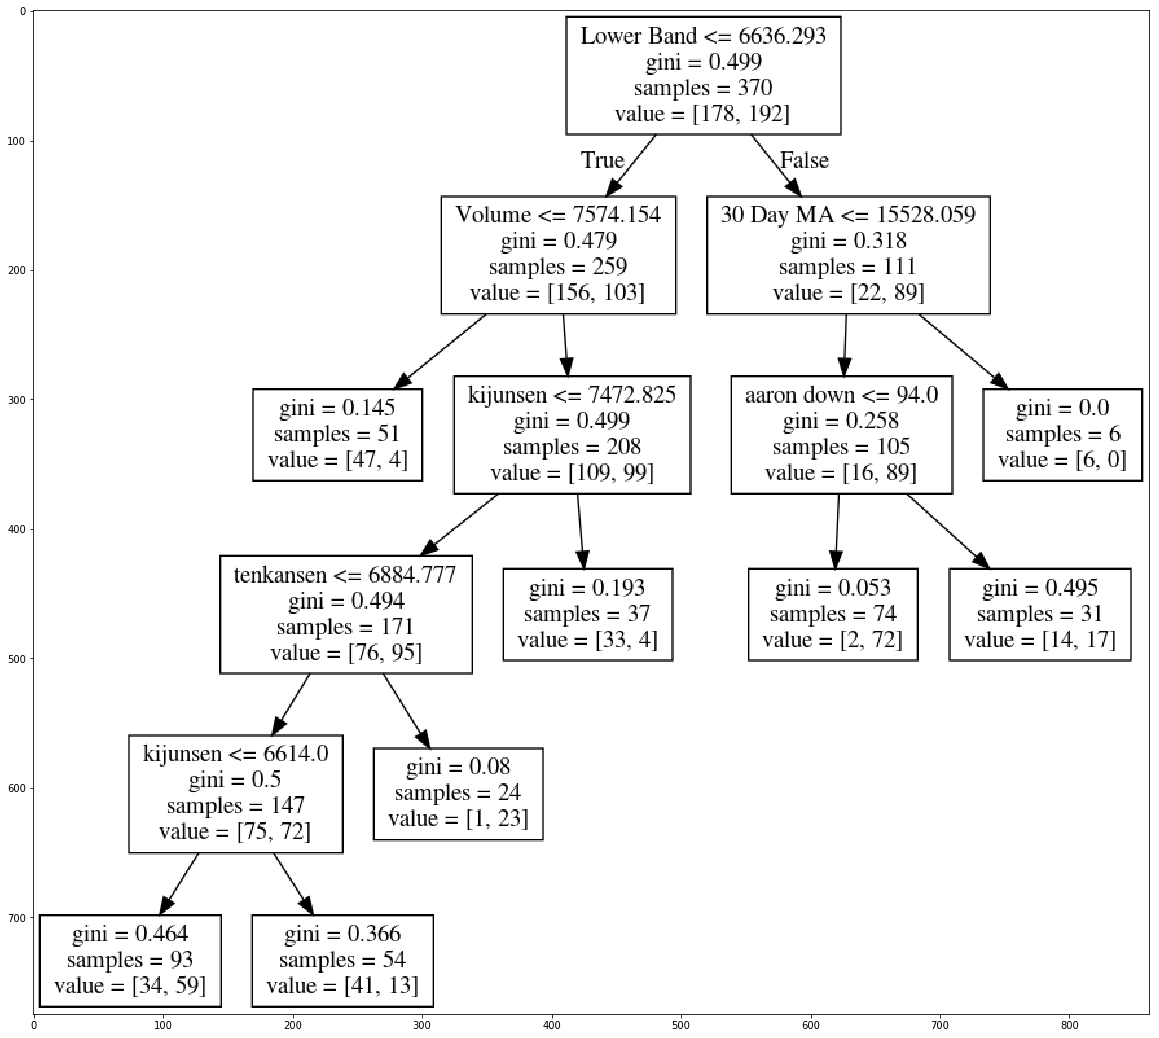

In [123]:
sig, acc = runStrategy()